In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras import layers
from keras.models import Model

#VIS
from keras.utils.vis_utils import plot_model

In [2]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    

    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [3]:
#Paths
pathTrain_Images = "imgs/train"
pathPropagate_Images =  "imgs/test"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


### Classes: 
c0: safe driving <br> c1: texting - right <br>c2: talking on the phone - right <br> c3: texting - left <br> c4: talking on the phone - left <br> c5: operating the radio <br>c6: drinking <br> c7: reaching behind <br>c8: hair and makeup <br>c9: talking to passenger

17939
(128, 128, 3)


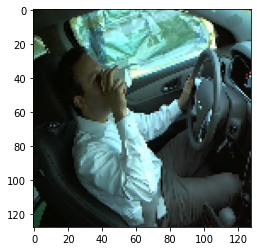

Class: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:
print(len(X_Train))
print(X_Train[52].shape)
im = X_Train[52]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[52]))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

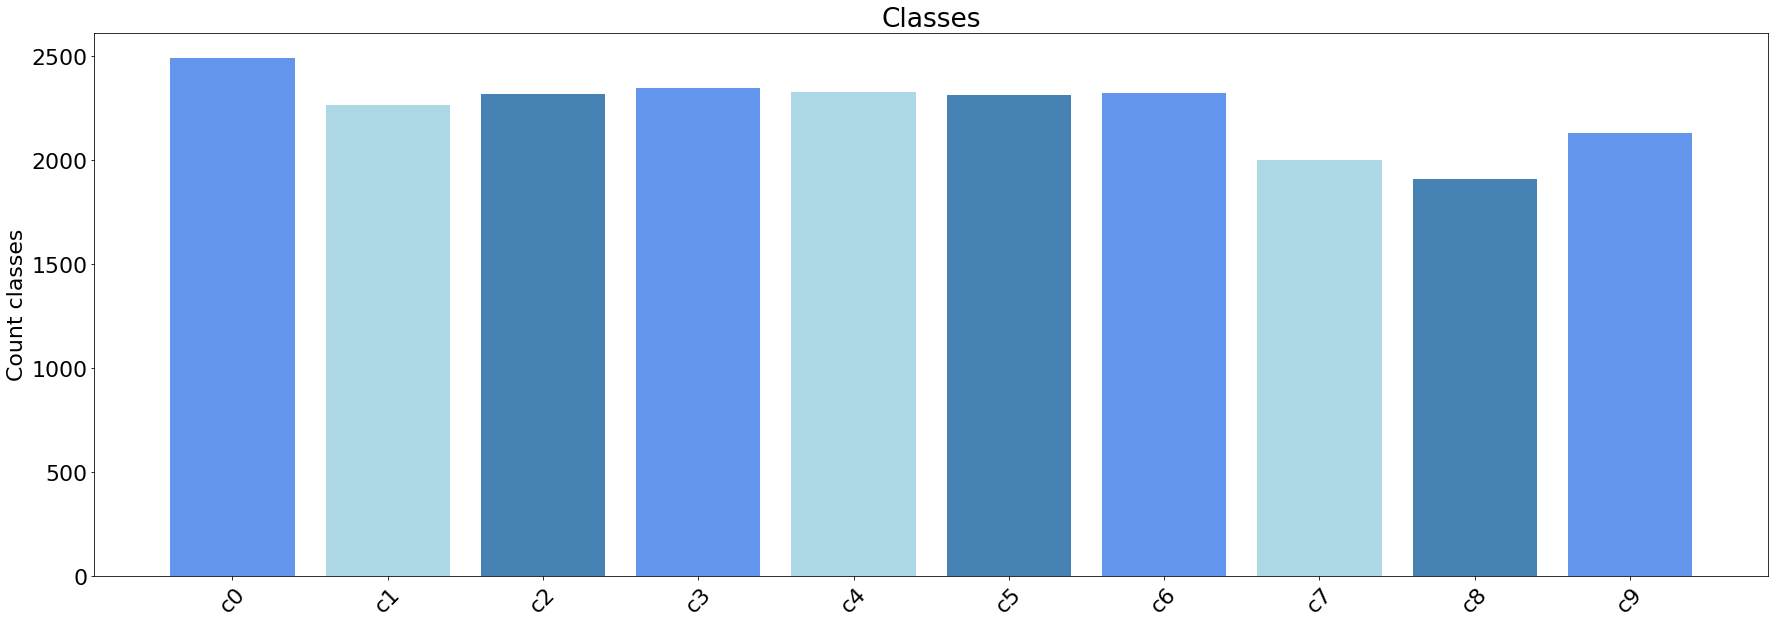

In [5]:
data_file = pd.read_csv("driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

## Create Architecture

In [ ]:
# Architecture 1 - ResNet
# https://medium.com/datadriveninvestor/five-powerful-cnn-architectures-b939c9ddd57b
# takes forever
from keras import layers
from keras.models import Model

def _after_conv(in_tensor):
    norm = layers.BatchNormalization()(in_tensor)
    return layers.Activation('relu')(norm)

def conv1(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=1)(in_tensor)
    return _after_conv(conv)

def conv1_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=2)(in_tensor)
    return _after_conv(conv)

def conv3(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(in_tensor)
    return _after_conv(conv)

def conv3_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(in_tensor)
    return _after_conv(conv)

def resnet_block_wo_bottlneck(in_tensor, filters, downsample=False):
    if downsample:
        conv1_rb = conv3_downsample(in_tensor, filters)
    else:
        conv1_rb = conv3(in_tensor, filters)
    conv2_rb = conv3(conv1_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    result = layers.Add()([conv2_rb, in_tensor])

    return layers.Activation('relu')(result)

def resnet_block_w_bottlneck(in_tensor,
                             filters,
                             downsample=False,
                             change_channels=False):
    if downsample:
        conv1_rb = conv1_downsample(in_tensor, int(filters/4))
    else:
        conv1_rb = conv1(in_tensor, int(filters/4))
    conv2_rb = conv3(conv1_rb, int(filters/4))
    conv3_rb = conv1(conv2_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    elif change_channels:
        in_tensor = conv1(in_tensor, filters)
    result = layers.Add()([conv3_rb, in_tensor])

    return result

def _pre_res_blocks(in_tensor):
    conv = layers.Conv2D(64, 7, strides=2, padding='same')(in_tensor)
    conv = _after_conv(conv)
    pool = layers.MaxPool2D(3, 2, padding='same')(conv)
    return pool

def _post_res_blocks(in_tensor, n_classes):
    pool = layers.GlobalAvgPool2D()(in_tensor)
    preds = layers.Dense(n_classes, activation='softmax')(pool)
    return preds

def convx_wo_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_wo_bottlneck(res, filters, downsample_1)
        else:
            res = resnet_block_wo_bottlneck(res, filters)
    return res

def convx_w_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_w_bottlneck(res, filters, downsample_1, not downsample_1)
        else:
            res = resnet_block_w_bottlneck(res, filters)
    return res

def _resnet(in_shape=(224,224,3),
            n_classes=10,
            opt='sgd',
            convx=[64, 128, 256, 512],
            n_convx=[2, 2, 2, 2],
            convx_fn=convx_wo_bottleneck):
    in_layer = layers.Input(in_shape)

    downsampled = _pre_res_blocks(in_layer)

    conv2x = convx_fn(downsampled, convx[0], n_convx[0])
    conv3x = convx_fn(conv2x, convx[1], n_convx[1], True)
    conv4x = convx_fn(conv3x, convx[2], n_convx[2], True)
    conv5x = convx_fn(conv4x, convx[3], n_convx[3], True)

    preds = _post_res_blocks(conv5x, n_classes)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
	              metrics=["accuracy"])
    return model

def resnet18(in_shape=(224,224,3), n_classes=10, opt='sgd'):
    return _resnet(in_shape, n_classes, opt)

def resnet34(in_shape=(224,224,3), n_classes=10, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  n_convx=[3, 4, 6, 3])

def resnet50(in_shape=(224,224,3), n_classes=10, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 4, 6, 3],
                  convx_w_bottleneck)

def resnet101(in_shape=(224,224,3), n_classes=10, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 4, 23, 3],
                  convx_w_bottleneck)

def resnet152(in_shape=(224,224,3), n_classes=10, opt='sgd'):
    return _resnet(in_shape,
                  n_classes,
                  opt,
                  [256, 512, 1024, 2048],
                  [3, 8, 36, 3],
                  convx_w_bottleneck)



In [ ]:
# Architecture 2 - LeNet5
# bad accuracy

def lenet_5(in_shape=(32,32,3), n_classes=10, opt='sgd'):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(filters=20, kernel_size=5,
                          padding='same', activation='relu')(in_layer)
    pool1 = layers.MaxPool2D()(conv1)
    conv2 = layers.Conv2D(filters=50, kernel_size=5,
                          padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPool2D()(conv2)
    flatten = layers.Flatten()(pool2)
    dense1 = layers.Dense(500, activation='relu')(flatten)
    preds = layers.Dense(n_classes, activation='softmax')(dense1)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt, 
                  metrics=["accuracy"])
    return model

In [ ]:
# Architecture 3 - VGGNet
# takes forever

from functools import partial

conv3 = partial(layers.Conv2D,
                kernel_size=3,
                strides=1,
                padding='same',
                activation='relu')

def block(in_tensor, filters, n_convs):
    conv_block = in_tensor
    for _ in range(n_convs):
        conv_block = conv3(filters=filters)(conv_block)
    return conv_block

def _vgg(in_shape=(227,227,3),
         n_classes=10,
         opt='sgd',
         n_stages_per_blocks=[2, 2, 3, 3, 3]):
    in_layer = layers.Input(in_shape)

    block1 = block(in_layer, 64, n_stages_per_blocks[0])
    pool1 = layers.MaxPool2D()(block1)
    block2 = block(pool1, 128, n_stages_per_blocks[1])
    pool2 = layers.MaxPool2D()(block2)
    block3 = block(pool2, 256, n_stages_per_blocks[2])
    pool3 = layers.MaxPool2D()(block3)
    block4 = block(pool3, 512, n_stages_per_blocks[3])
    pool4 = layers.MaxPool2D()(block4)
    block5 = block(pool4, 512, n_stages_per_blocks[4])
    pool5 = layers.MaxPool2D()(block5)
    flattened = layers.GlobalAvgPool2D()(pool5)

    dense1 = layers.Dense(4096, activation='relu')(flattened)
    dense2 = layers.Dense(4096, activation='relu')(dense1)
    preds = layers.Dense(10, activation='softmax')(dense2)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
	              metrics=["accuracy"])
    return model

def vgg16(in_shape=(227,227,3), n_classes=10, opt='sgd'):
    return _vgg(in_shape, n_classes, opt)

def vgg19(in_shape=(227,227,3), n_classes=10, opt='sgd'):
    return _vgg(in_shape, n_classes, opt, [2, 2, 4, 4, 4])


In [ ]:
# Architecture 4 - AlexNet
# bad accuracy

def alexnet(in_shape=(227,227,3), n_classes=10, opt='sgd'):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(96, 11, strides=4, activation='relu')(in_layer)
    pool1 = layers.MaxPool2D(3, 2)(conv1)
    conv2 = layers.Conv2D(256, 5, strides=1, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPool2D(3, 2)(conv2)
    conv3 = layers.Conv2D(384, 3, strides=1, padding='same', activation='relu')(pool2)
    conv4 = layers.Conv2D(256, 3, strides=1, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPool2D(3, 2)(conv4)
    flattened = layers.Flatten()(pool3)
    dense1 = layers.Dense(4096, activation='relu')(flattened)
    drop1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(4096, activation='relu')(drop1)
    drop2 = layers.Dropout(0.5)(dense2)
    preds = layers.Dense(n_classes, activation='softmax')(drop2)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
	              metrics=["accuracy"])
    return model


In [6]:
model = keras.models.Sequential()

model.add(keras.layers.InputLayer(
    input_shape=(128, 128, 3)
))

model.add(
    keras.layers.Conv2D(
        filters=32,
        kernel_size=(5,5),
        strides = (1,1),
        padding='same',
        activation='relu',
        name='Conv_1'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_1'))#Image_size: 32*64*64(32 filters,image_size 64*64)

model.add(
    keras.layers.Conv2D(
        filters = 64,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_2'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_2'))#Image_size: 64*32*32(64 filters,image_size 32*32)

model.add(
    keras.layers.Conv2D(
        filters = 128,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_3'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_3'))#Image_size: 128*16*16(128 filters,image_size 16*16)

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_4'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_4'))#Image_size: 256*8*8(256 filters,image_size 8*8)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu',name = 'fc_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512, activation='relu',name = 'fc_2'))
model.add(keras.layers.Dense(units=10,activation='softmax',name = 'fc_3'))
model.save('/tmp/model')
#model.compute_output_shape(input_shape=(256,8,8,1))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/model/assets


In [ ]:
import keras
keras.__version__
from keras import models
from keras import layers

In [ ]:
def get_my_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(480, 640, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [7]:
model.summary()
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        51264     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 32, 32, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 32, 32, 128)       204928    
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 16, 16, 128)       0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 16, 16, 256)       8

In [8]:
history = model.fit(x = X_Train, y = Y_Train, epochs = 10,
                    batch_size = 500, verbose = 1, 
                    validation_split = 0.2)

Epoch 1/10
29/29 [==============================] - 665s 23s/step - loss: 24.4974 - accuracy: 0.1956 - val_loss: 2.1365 - val_accuracy: 0.2667
Epoch 2/10
29/29 [==============================] - 643s 22s/step - loss: 2.0386 - accuracy: 0.3325 - val_loss: 1.4186 - val_accuracy: 0.5240
Epoch 3/10
29/29 [==============================] - 664s 23s/step - loss: 1.0445 - accuracy: 0.6450 - val_loss: 0.5941 - val_accuracy: 0.8018
Epoch 4/10
29/29 [==============================] - 628s 22s/step - loss: 0.3450 - accuracy: 0.8947 - val_loss: 0.1361 - val_accuracy: 0.9596
Epoch 5/10
29/29 [==============================] - 595s 21s/step - loss: 0.0635 - accuracy: 0.9836 - val_loss: 0.0456 - val_accuracy: 0.9883
Epoch 6/10
29/29 [==============================] - 614s 21s/step - loss: 0.0150 - accuracy: 0.9967 - val_loss: 0.0287 - val_accuracy: 0.9914
Epoch 7/10
29/29 [==============================] - 590s 20s/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0335 - val_accuracy: 0.9908
Epoch

In [9]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 45s 321ms/step - loss: 0.0245 - accuracy: 0.9944


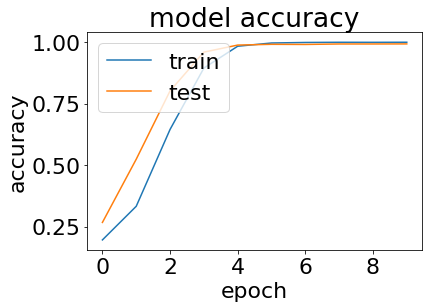

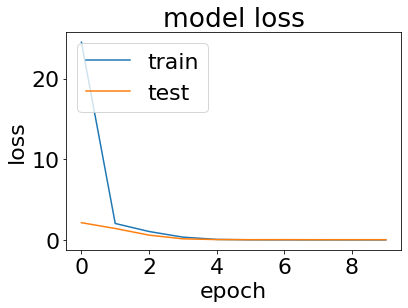

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

In [11]:
model_json = model.to_json()
model.save_weights('Train_weights_1.h5',overwrite = True)

In [12]:
model.load_weights('Train_weights_1.h5')

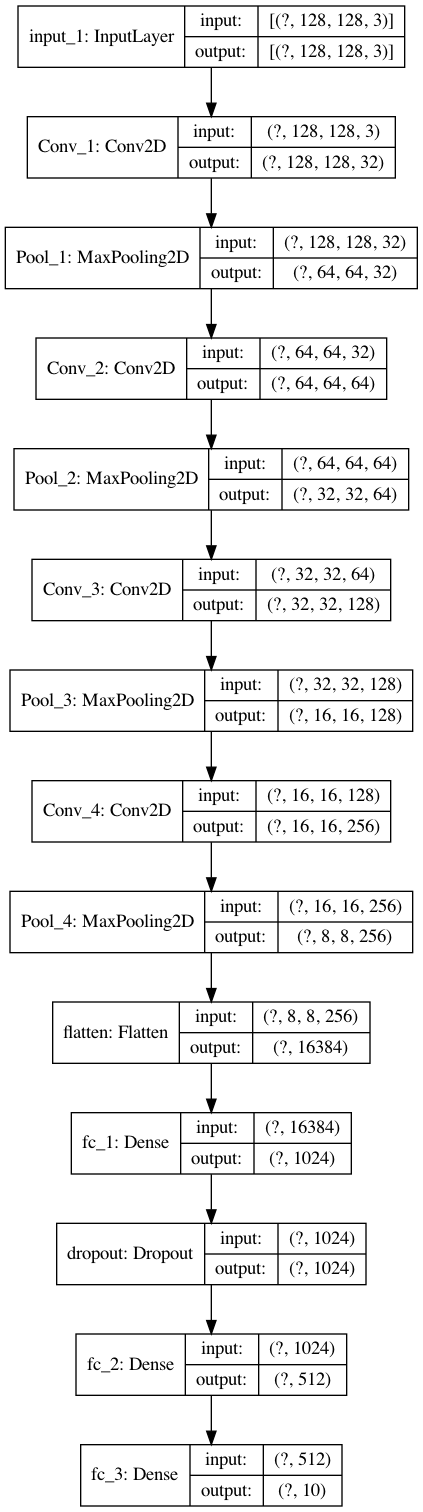

In [13]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

In [48]:

df = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})
def _submission(localpath,df):
    for imgs in glob.glob(os.path.join(localpath,'*.jpg')):
        test_image = image.load_img(imgs, target_size = (128, 128))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)

        arr_predict = model.predict(test_image)
        #print(imgs.split('/')[-1])
        df = df.append(
            {
                'img':imgs.split('/')[-1],
                'c0':round(arr_predict[0][0],2), 
                'c1':round(arr_predict[0][1],2),
                'c2':round(arr_predict[0][2],2),
                'c3':round(arr_predict[0][3],2),
                'c4':round(arr_predict[0][4],2),
                'c5':round(arr_predict[0][5],2),
                'c6':round(arr_predict[0][6],2),
                'c7':round(arr_predict[0][7],2),
                'c8':round(arr_predict[0][8],2),
                'c9':round(arr_predict[0][9],2)
            },
            ignore_index=True
        )
    return df

In [49]:
localpath = '/Users/longmini/Kyeongho/MSIS/3rdQ_2020fall/MSIS2636/DLproject/ourpics'
ourpics = _submission(localpath,df)

In [50]:
ourpics.shape

(23, 11)

In [51]:
ourpics

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,kenny8.jpg,0.00,0.0,0.00,0.98,0.00,0.00,0.0,0.00,0.00,0.02
1,KH52.jpg,0.01,0.0,0.00,0.63,0.00,0.35,0.0,0.00,0.00,0.01
2,KH53.jpg,0.00,0.0,0.00,0.09,0.00,0.91,0.0,0.00,0.00,0.00
3,KH51.jpg,0.00,0.0,0.00,0.03,0.00,0.68,0.0,0.00,0.00,0.29
4,KH50.jpg,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.19,0.81
5,KH55.jpg,0.00,0.0,0.00,0.03,0.00,0.97,0.0,0.00,0.00,0.00
6,KH73.jpg,0.00,0.0,0.00,0.01,0.00,0.99,0.0,0.00,0.00,0.00
7,KH58.jpg,0.00,0.0,0.00,0.01,0.00,0.99,0.0,0.00,0.00,0.00
8,KH59.jpg,0.00,0.0,0.00,0.02,0.00,0.97,0.0,0.00,0.00,0.00
9,KH49.jpg,0.21,0.0,0.00,0.04,0.00,0.00,0.0,0.00,0.14,0.60


In [52]:
ourpics.to_csv('ourpicspredict.csv',index = False)

In [101]:
test_image = image.load_img('ourpics/KH52.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = model.predict(test_image)

In [102]:
result

array([[6.9449944e-03, 2.5757363e-06, 6.1485039e-06, 6.3265842e-01,
        9.0388741e-05, 3.5195771e-01, 4.7696936e-05, 2.9166349e-08,
        1.1839491e-04, 8.1736883e-03]], dtype=float32)

In [103]:
for i in range(0,10):
    print("class", i, ":", round(result[0][i],2))

class 0 : 0.01
class 1 : 0.0
class 2 : 0.0
class 3 : 0.63
class 4 : 0.0
class 5 : 0.35
class 6 : 0.0
class 7 : 0.0
class 8 : 0.0
class 9 : 0.01
